### QMC + circuits

In [33]:
from qiskit.quantum_info import SparsePauliOp
from qutip import Qobj, qeye, tensor

def get_observables(n:int):

    """
    Returns a list with the observables being measured, 
    which in our case are the populations of the computational and 
    the coupled basis states (i.e., <\Pi_i> where \Pi_i = |i><i|).

    Parameters
    ----------

    n : int
        Number of qubits in the system's register (i.e., number of molecules).
    
    Returns
    -------
    list[SparsePauliOp]
        Observables

    """

    # The observables must be SparsePauliOps, so we are going to create them
    # using the from_operator method and from the matrix representation of the
    # projectors.

    # Basis definition

    ket_0 = Qobj([[1],[0]])
    ket_1 = Qobj([[0],[1]])

    # Computational basis 

    system_dim = 2**n

    #computational_basis = []
    #labels = []

    #for i in range(system_dimension):

        #zeros = [0]*system_dimension
        #zeros[i] = 1
        #computational_basis.append(np.array(zeros).reshape(system_dimension,1))
        #labels.append(''.join(str(x) for x in zeros))

    # Projectors are defined and stored in a dictionary 

    observables = {}
    #counter = 0

    sigmam = ket_0*ket_1.dag()
    sp_sm = sigmam.dag()*sigmam

    for i in range(-1, -n-1, -1): # Due to qiskits ordering we have to go backwards

        ops = [qeye(2)]*n
        ops[i] = sp_sm
        sig = tensor(ops)
        sig.dims = [[system_dim], [system_dim]]
        matrix_rep = sig.full()
        observables[str(-i-1)] = SparsePauliOp('I'*1).tensor(SparsePauliOp.from_operator(matrix_rep))

    return observables

<>:6: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_10504\947770619.py:6: SyntaxWarning: invalid escape sequence '\P'
  """


In [37]:
from merge_methods_CHAIN import solve_master_equation # For checking results
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2, Batch
import math
from qiskit.quantum_info import Statevector

#### SYSTEM PARAMETERS ####

n = 2
omega_m = [1.1]*n
g = [0.01]*(2*(n-1))
gamma = [0.8*(10**-6)]*n
initial_state = [0]*(2**n)
initial_state[-1] = 1
omega_c = 1.1
g = [0.001, 0.004]
kappa = [0.2]

#### SIMULATION PARAMETERS ####

t = np.linspace(0, 1750, 250)
r = 1
backend = AerSimulator()
optimization_level = 3
options = {}
options = {'default_shots' : 1}
           #'resilience_level' : 1,
           #'optimization_level' : 1}
shots = options['default_shots']
walks = 10**2

#### SYSTEM VARIABLES ####

delta = [ x - omega_c for x in omega_m ]
omega_eff = [ omega_m[i] + (delta[i]*(g[i]**2))/((0.5*kappa[0])**2 + delta[i]**2) for i in range(n) ]
g_eff = [ (0.5*g[i]*g[i+1]*(delta[i] + delta[i+1]))/((kappa[0]/2)**2 + delta[i]*delta[i+1]) for i in range(n-1) ]
gamma_eff = [ gamma[i] + (kappa[0]*(g[i]**2))/((0.5*kappa[0])**2 + delta[i]**2) for i in range(n) ]
gamma_cross = [ (g[i]*g[i+1]*(kappa[0]))/((kappa[0]/2)**2 + delta[i]*delta[i+1]) for i in range(n-1)]   
gamma_plus = [(gamma_eff[i] + gamma_eff[i+1])/2 + gamma_cross[i] for i in range(n-1)]
gamma_minus = [(gamma_eff[i] + gamma_eff[i+1])/2 - gamma_cross[i] for i in range(n-1)]

#### CORE CIRCUIT (HAMILTONIAN EVO) ####

system = QuantumRegister(n, 'q')
ancilla = QuantumRegister(1,'a')
classical_register = ClassicalRegister(1, 'c')

delta_t = Parameter('$t$')/r
beta = [ 2*omega_eff[j]*delta_t for j in range(n) ]
alpha = [ g_eff[j]*delta_t for j in range(n-1) ]

init_qc = QuantumCircuit(system, ancilla, classical_register)
initial_statevector = Statevector(initial_state)
init_qc.initialize(params = initial_statevector, qubits = system, normalize = True)

core_qc = QuantumCircuit(system, ancilla, classical_register)

for i in range(n):

    core_qc.rz(beta[i], system[i])

for j in range(0, n-1, 2):

    core_qc.ryy(alpha[j], qubit1 = system[j], qubit2 = system[j+1])
    core_qc.rxx(alpha[j], qubit1 = system[j], qubit2 = system[j+1])

    if n > 2:

        for k in range(1, n-1, 2):

            core_qc.ryy(alpha[k], qubit1 = system[k], qubit2 = system[k+1])
            core_qc.rxx(alpha[k], qubit1 = system[k], qubit2 = system[k+1])


#### MAIN LOOP ####

evs = {}
cum_sum = {}

for m in range(n):

    cum_sum[str(m)] = np.zeros(len(t))

for l in range(walks):

    qcs = []

    for i in t:

        decay = {'1': False, '0': False} 

        qc = core_qc.copy()
        qc.compose(init_qc, front = True, inplace = True)

        p_plus = 1 - np.exp(-gamma_plus[0]*i/r)
        p_minus = 1 - np.exp(-gamma_minus[0]*i/r)

        for j in range(r):
        
            epsilon = np.random.rand()

            # Tengo primero que checkear si voy a decaer. En caso afirmativo, tendría que meter una toffoli, medir una ancilla y asegurarme si estoy en E o no. Si estoy en E, hago el decay
            # reverse y si no, el standard, i.e., si me sale que la p+ es mayor q epsilon y además estoy en E, tengo que bajar al lambda+ (aplicar x a q_0 en vez de q_1).
            # Si me sale que no voy a decaer, no tengo que meter la toffoli ni hacer nada, simplemente appendear la hamiltonian evo y seguir con el next trotter step.

            if ((p_plus or p_minus) > epsilon) and (decay['0'] == False or decay['1'] == False):

                qc.ccx(system[0], system[1], ancilla)
                qc.measure(ancilla, classical_register)

                with qc.if_test((classical_register, 0)) as else_: # We are NOT in E -> Standard decay

                    if p_plus > epsilon:

                        qc.reset(system[1])
                        decay['1'] == True
                    
                    if p_minus > epsilon:

                        qc.reset(system[0])
                        decay['0'] == True
                
                with else_: # We are in E -> Reverse decay

                    if p_plus > epsilon:

                        qc.reset(system[0])
                        decay['0'] == True
                    
                    if p_minus > epsilon:

                        qc.reset(system[1])
                        decay['1'] == True

            qc.compose(core_qc.copy(), inplace = True)
    
        qc.measure_all()
        qcs.append(qc)

    pm = generate_preset_pass_manager(optimization_level, backend)
    isa_circuits = pm.run(qcs)
    #reshaped_obs = np.fromiter(isa_observables, dtype=object)
    #reshaped_obs = reshaped_obs.reshape((len(observables), 1))

    pubs = [(circ, param) for circ, param in zip(isa_circuits,t)]

    with Batch(backend=backend):

        sampler = SamplerV2(options = options)
        job = sampler.run(pubs)
    
    values = {'0':[], '1':[]}

    for k in range(len(t)):

        pub_result = job.result()[k]
        counts = pub_result.data.meas.get_counts()
        states = [key[math.trunc(n/2):] for key in counts.keys()]
        coeff = [ np.sqrt(counts[key]/shots) for key in counts.keys()] # Normalized coefficients
        eigenvalues = [1, -1] # Z eigenvalues

        for o in range(n):

            values[str(o)].append(0.5*( 1 - sum([ (coeff[j]**2)*eigenvalues[int(states[j][-o-1])] for j in range(len(states)) ])))

    for key in values.keys():

        evs[key] = cum_sum[key] + np.array(values[key])

        cum_sum[key] = evs[key]

av_evs = {}

for key in evs:

    av_evs[key] = evs[key]/walks

evs_markov = solve_master_equation(n, omega_m, omega_c, gamma, kappa, g, t, initial_state, 'markovian')

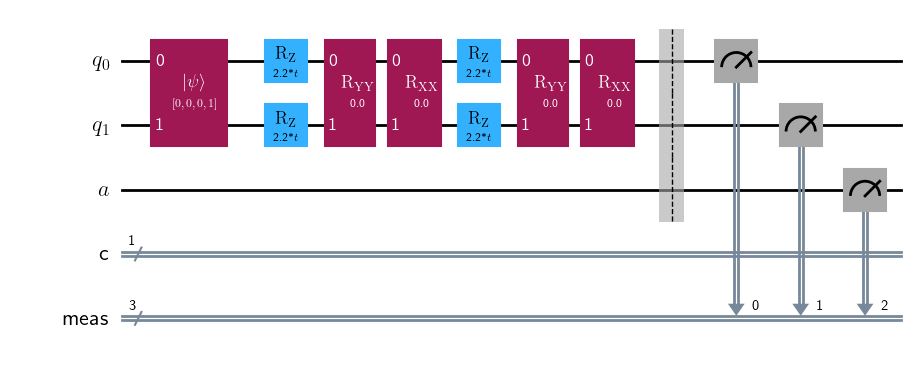

In [50]:
qcs[-9].draw('mpl')

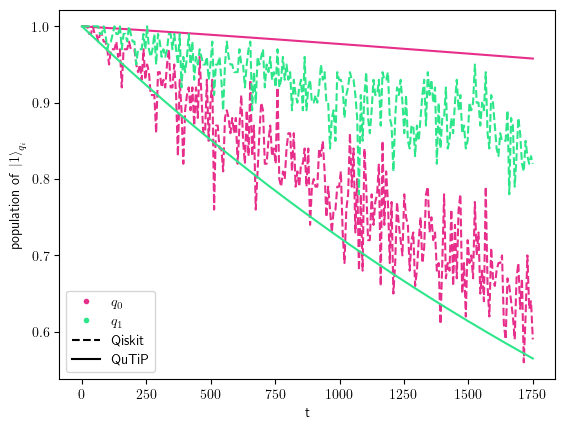

In [51]:
from generate_complementary_colors import generate_complementary_colors
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

colors = generate_complementary_colors(len(evs.keys()), palette_type = 'default', start_color = 'hotpink')

for qubit in evs.keys():

    plt.plot(t, evs_markov[qubit], color = colors[int(qubit)], linestyle = 'solid')
    plt.plot(t, av_evs[qubit], color = colors[int(qubit)], linestyle = 'dashed')
    plt.plot(np.NaN, np.NaN, linestyle = 'None', marker = '.', color =  colors[int(qubit)], label = '$q_{%i}$' %int(qubit))

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', label = 'Qiskit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'QuTiP')
plt.xlabel('t')
plt.ylabel('population of $\\left.|1 \\right>_{q_i}$')
#plt.yscale('log')
#plt.title(key)
plt.legend()
#plt.savefig('markovian circuit for %s' %key)
plt.show()

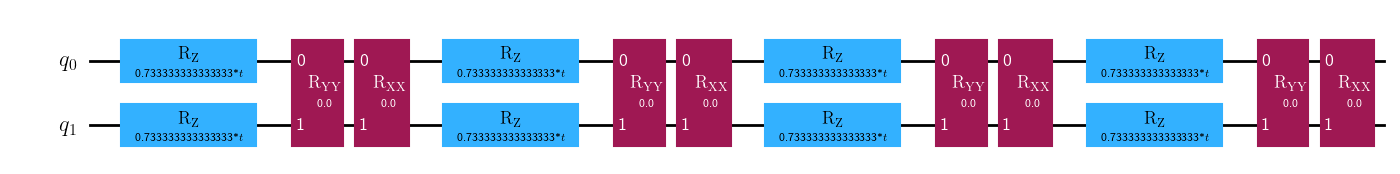

In [27]:
qcs[-1].draw('mpl')